In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import copy, math

In [2]:
mnist = fetch_openml('mnist_784', version=1)
data = mnist.data
labels = labels = mnist.target.astype(int)  # Convert labels to integers
scaler = StandardScaler()
datas = np.array(data)
x = scaler.fit_transform(datas)
y = np.array(labels)

In [5]:
def preactivation(x,w,b):
    z = np.dot(x,w) + b
    return z

def relu(z):
    return np.maximum(0, z)

def forward_propagation(x, w1, b1):
    z1 = preactivation(x, w1, b1)   # Compute Z_1 (pre-activation)
    a1 = relu(z1)                    # Apply ReLU to Z_1
    return a1,z1

# def softmax(z):
#     expZ = np.exp(z)
#     sum_expz = np.sum(expZ,axis=1,keepdims=True)
#     return expZ/sum_expz

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)  # Subtract max to avoid overflow
    expZ = np.exp(z)
    sum_expz = np.sum(expZ, axis=1, keepdims=True)
    return expZ / sum_expz

    
def softmaxpropogation(a,w,b):
    z2 = preactivation(a,w,b)
    a2 = softmax(z2)
    return a2,z2
    

In [6]:
# def cross_entropy_loss(y, a2):
#     # y is the true labels (one-hot encoded), a2 is the predicted probabilities
#     m = y.shape[0]  # Number of samples
#     log_a2 = np.log(a2-1e-10)  # Log of predicted probabilities

#     # Compute the cross-entropy loss (mean over all samples)
#     loss = -np.sum(y * log_a2) / m
#     return loss

def cross_entropy_loss(y, a2):
    # Clip a2 to avoid log(0)
    epsilon = 1e-10
    a2 = np.clip(a2, epsilon, 1. - epsilon)
    log_a2 = np.log(a2)  # Log of predicted probabilities
    m = y.shape[0]  # Number of samples
    loss = -np.sum(y * log_a2) / m
    return loss


In [7]:
def full_forward_propagation(x, w1, b1, w2, b2):
    a1,z1 = forward_propagation(x, w1, b1)  # Hidden layer forward propagation
    a2,z2 = softmaxpropogation(a1, w2, b2)  # Output layer forward propagation
    return a1,a2,z1,z2


In [8]:
def gradientfn(x,y,a1,a2,z1,z2,w1,w2,alpha):
    dA2 = a2 - y
    dW2 = np.dot(a1.T,dA2)
    dB2 = np.sum(dA2, axis=0, keepdims=True)
    dA1 = np.dot(dA2,w2.T)
    dZ1 = dA1 * (z1 > 0)  # Element-wise multiplication with the ReLU derivative
    dW1 = np.dot(x.T, dZ1)  # Gradient of the loss wrt W1
    dB1 = np.sum(dZ1, axis=0, keepdims=True)  # Gradient of the loss wrt B1
    return dW1,dW2,dB1,dB2


In [9]:
def gradientDescent(x,y,w1,w2,b1,b2,alpha):
    a1,a2,z1,z2 = full_forward_propagation(x,w1,b1,w2,b2)
    dW1,dW2,dB1,dB2 = gradientfn(x,y,a1,a2,z1,z2,w1,w2,alpha)
    w1 -= alpha * dW1
    b1 -= alpha * dB1
    w2 -= alpha * dW2
    b2 -= alpha * dB2
    return w1,b1,w2,b2

In [174]:
def iterations(x,y,w1,w2,b1,b2,alpha,num_epochs):
    for epoch in range(num_epochs):
        # Perform forward propagation and compute gradients
        w1,b1,w2,b2 = gradientDescent(x, y, w1, w2, b1, b2, alpha)
        
        # Calculate loss for this epoch
        a1, a2, z1, z2 = full_forward_propagation(x, w1, b1, w2, b2)
        loss = cross_entropy_loss(y, a2)
        
        # Append the loss value for this epoch to track the training progress
        loss_history.append(loss)
        # if epoch % 10 == 0 and epoch > 0:
        #     alpha *= 0.999
        
        # Optionally print the loss every 100 epochs or so
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss}")
    return w1,w2,b1,b2


In [11]:
wi1 = tf.random.normal((784, 128), dtype=tf.float64) * 0.01  # Weight matrix for input to hidden
# wi1 = tf.zeros((784, 128), dtype=tf.float64) * 0.01  # Weight matrix for input to hidden
bi1 = tf.zeros((1, 128), dtype=tf.float64)                  # Bias vector for hidden layer

# Output layer
wi2 = tf.random.normal((128, 10), dtype=tf.float64) * 0.01  # Weight matrix for hidden to output
# wi2 = tf.zeros((128, 10), dtype=tf.float64) * 0.01  # Weight matrix for hidden to output
bi2 = tf.zeros((1, 10), dtype=tf.float64)                  # Bias vector for output layer

# Convert to NumPy if using custom implementation
win1 = wi1.numpy()
bin1 = bi1.numpy()
win2 = wi2.numpy()
bin2 = bi2.numpy()
print(win1)

[[-0.0050098  -0.00514778  0.00019425 ...  0.03293129 -0.0134562
   0.01356228]
 [ 0.00068705  0.00357628  0.00600486 ...  0.00488953  0.01195254
   0.00066478]
 [ 0.00204464 -0.00949793  0.00481813 ... -0.00309441 -0.0121009
   0.00714132]
 ...
 [-0.00625202  0.00676532 -0.00418931 ...  0.00810874 -0.00366389
   0.00446558]
 [ 0.00869442  0.0212202  -0.00272726 ...  0.00486357 -0.00713128
  -0.00258702]
 [ 0.00250173  0.00315626 -0.00147947 ...  0.0055131  -0.0016986
   0.00435688]]


In [176]:
x_small, _, y_small, _ = train_test_split(x, y, train_size=69000, random_state=42)
print(x_small.shape)
# x_small = np.delete(x_small, 21018, axis=0)
# y_small = np.delete(y_small, 21018, axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_small, y_small, test_size=0.3, random_state=42)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

(69000, 784)


In [177]:
def one_hot_encode(y, num_classes):
    m = y.shape[0]  # Number of samples
    one_hot_y = np.zeros((m, num_classes))
    one_hot_y[np.arange(m), y] = 1  # Set the correct class label to 1
    return one_hot_y
y_train_one_hot = one_hot_encode(y_train,10)
# print(y_small[21018])
# Remove the problematic row from x_train and y_train (or x_test, y_test)


In [193]:
w1 = copy.deepcopy(win1)
b1 = copy.deepcopy(bin1)
w2 = copy.deepcopy(win2)
b2 = copy.deepcopy(bin2)
# Initialize loss history to track progress
loss_history = []
# Set number of epochs
num_epochs = 100  # or any number that works for your dataset
alpha = 0.000029
w1,w2,b1,b2 = iterations(x_train,y_train_one_hot,w1,w2,b1,b2,alpha,num_epochs)

Epoch 0/100, Loss: 2.213236294689128
Epoch 10/100, Loss: 0.4759556870588292
Epoch 20/100, Loss: 0.24562352160501155
Epoch 30/100, Loss: 0.2006705129382914
Epoch 40/100, Loss: 0.17276922341384782
Epoch 50/100, Loss: 0.15204972477849946
Epoch 60/100, Loss: 0.13573812952232336
Epoch 70/100, Loss: 0.12252016414943595
Epoch 80/100, Loss: 0.11174163904439356
Epoch 90/100, Loss: 0.10265706606186689


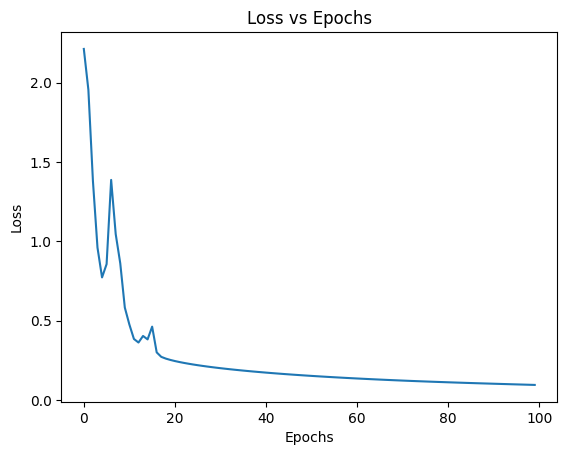

In [194]:
plt.plot(loss_history)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [195]:
def predict(x, w1, b1, w2, b2):
    a1, a2, _, _ = full_forward_propagation(x, w1, b1, w2, b2)
    return np.argmax(a2, axis=1)  # The class with the highest probability


In [196]:
pred_train = predict(x_train,w1,b1,w2,b2)
pred_test = predict(x_test,w1,b1,w2,b2)
acc_train = np.mean(pred_train == y_train)
acc_test = np.mean(pred_test == y_test)
print(acc_train,acc_test)

0.9736231884057971 0.9609661835748792


In [208]:
# alpha = 0.000029
# 0.9736231884057971 0.9609661835748792

In [132]:
y[21019]

1

In [204]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.datasets import mnist

In [205]:
# Define a simple feedforward neural network
model = Sequential([
    Input(shape=(784,)),
    Dense(128, activation='relu', input_shape=(784,)),  # Hidden layer with 128 neurons
    Dense(10, activation='softmax')                    # Output layer with 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [206]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8776 - loss: 0.4322 - val_accuracy: 0.9556 - val_loss: 0.1689
Epoch 2/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9673 - loss: 0.1148 - val_accuracy: 0.9640 - val_loss: 0.1368
Epoch 3/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9799 - loss: 0.0683 - val_accuracy: 0.9648 - val_loss: 0.1455
Epoch 4/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9836 - loss: 0.0576 - val_accuracy: 0.9639 - val_loss: 0.1525
Epoch 5/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9881 - loss: 0.0378 - val_accuracy: 0.9681 - val_loss: 0.1601
Epoch 6/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9914 - loss: 0.0298 - val_accuracy: 0.9707 - val_loss: 0.1500
Epoch 7/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9930 - loss: 0.0224 - val_accuracy: 0.9697 - val_loss: 0.1676
Epoch 8/10
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9939 - loss: 0.0201 

647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9667 - loss: 0.2004
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9940 - loss: 0.0215
Test Accuracy: 0.9681


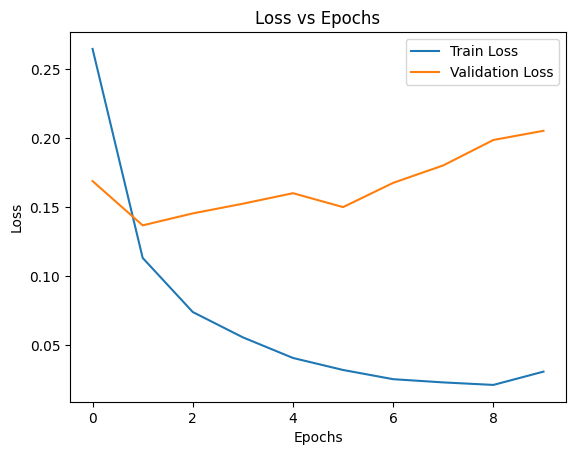

In [207]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print(f"Test Accuracy: {test_accuracy:.4f}")
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()